# Solución 1

Solución 1 propuesta para la predicción de cáncer de pulmon.


La primera solución planteada se basa en un algoritmo genético para la predicción de cancer de pulmón. Contamos con un conjunto de datos en el que las observaciones hacen referencia a diferentes personas, con 15 variables predictoras que nos ayudarán a predecir si cada observación tiene o no cancer de pulmón. Todas las variables contenidas en el conjunto de datos serán binarias para hacer la predicción.

La codificación consiste en un cromosoma en base tres, representado como una array de dimensión 1xN, siendo N el numero de variables predictoras. Los valores (genes) de este genotipo pueden ser 0, 1 o 2. En cuento al fenotipo o interpretación de esta codificación, consiste en que cada gen se corresponde con un atributo, si el gen vale 0, solo hará match si el atributo correspondiente tiene también valor 0, por el contrario si el gen 1, con el valor 1, y el gen 2, con ambos.

Cada uno de estos cromosomas es un individuo que será interpretado como un potencial clasificador, el objetivo es encontrar el mejor de ellos con un algoritmo genético y tomarlo como solución final



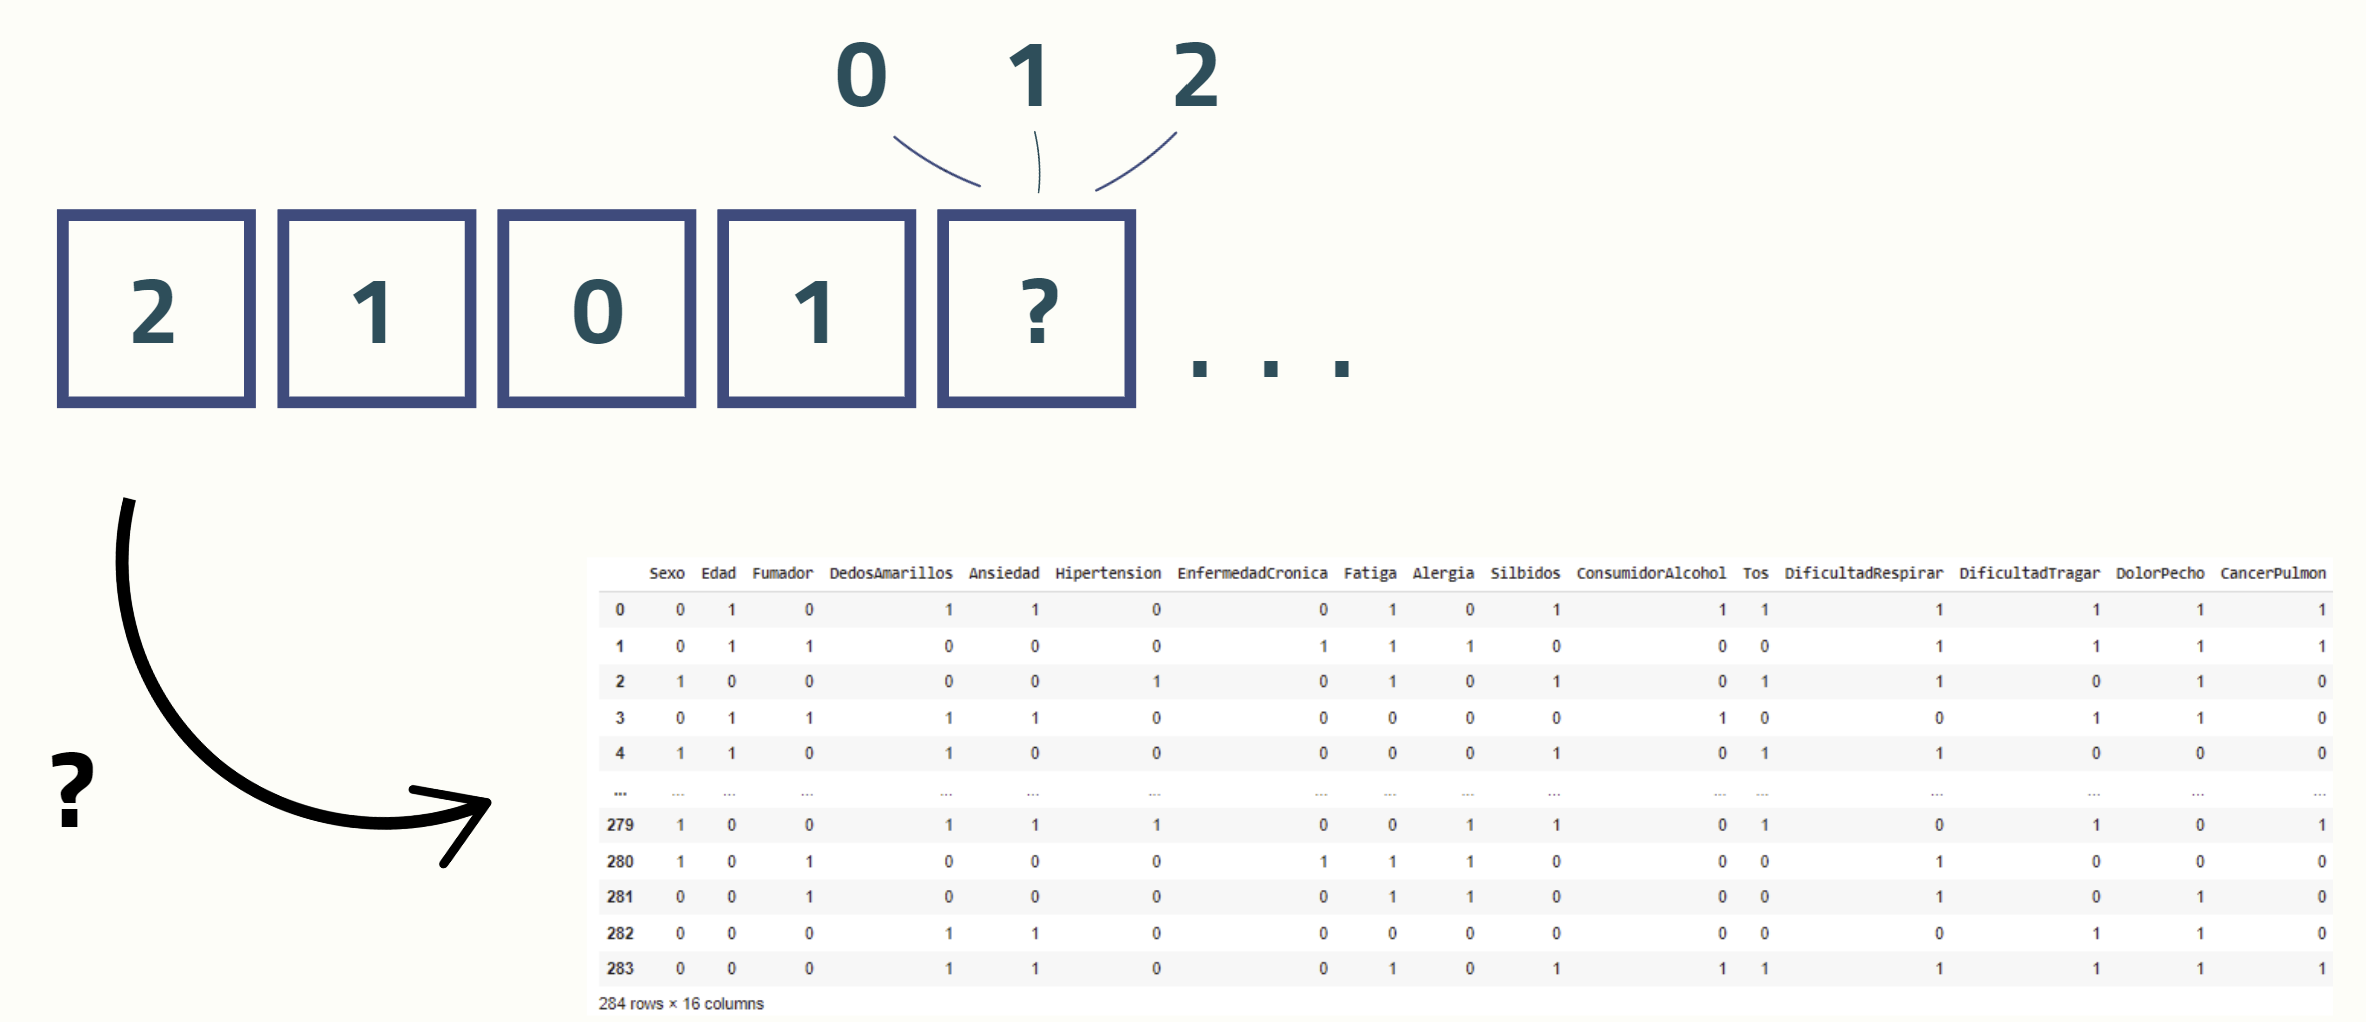

In [ ]:
from IPython.display import Image
Image('Codificacion.png')

Una vez tenemos correctamente definida la codificación, pasamos a definir la población inicial e implementar el proceso iterativo del algoritmo genético. Todas estas fases serán descritas a continuación junto a los bloques de código correspondientes.

Para comenzar a implementar nuestra solución, incluimos los importas necesarios y fijamos la semilla a un valor concreto para obtener siempre los mismos resultados.

In [ ]:
import pandas as pd
import random
import numpy as np
import torch
from google.colab import drive
from random import randint
from sklearn.metrics import accuracy_score

In [ ]:
# Set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

# Lectura de los datos

In [ ]:
# Montamos el drive:
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Computación evolutiva/LungCancer.csv"
#path = "/content/drive/MyDrive/IA Master/Computación Evolutiva/Final Project/LungCancer.csv"

Mounted at /content/drive


In [ ]:
data=pd.read_csv(path)
data

Sexo  Edad  Fumador  DedosAmarillos  Ansiedad  Hipertension  \
0      M    69        0               1         1             0   
1      M    74        1               0         0             0   
2      F    59        0               0         0             1   
3      M    63        1               1         1             0   
4      F    63        0               1         0             0   
..   ...   ...      ...             ...       ...           ...   
279    F    59        0               1         1             1   
280    F    59        1               0         0             0   
281    M    55        1               0         0             0   
282    M    46        0               1         1             0   
283    M    60        0               1         1             0   

     EnfermedadCronica  Fatiga  Alergia  Silbidos  ConsumidorAlcohol  Tos  \
0                    0       1        0         1                  1    1   
1                    1       1        1         0                  0    0   
2                    0       1        0         1                  0    1   
3                    0       0        0         0                  1    0   
4                    0       0        0         1                  0    1   
..                 ...     ...      ...       ...                ...  ...   
279                  0       0        1         1                  0    1   
280                  1       1        1         0                  0    0   
281                  0       1        1         0                  0    0   
282                  0       0        0         0                  0    0   
283                  0       1        0         1                  1    1   

     DificultadRespirar  DificultadTragar  DolorPecho  CancerPulmon  
0                     1                 1           1             1  
1                     1                 1           1             1  
2                     1                 0           1             0  
3                     0                 1           1             0  
4                     1                 0           0             0  
..                  ...               ...         ...           ...  
279                   0                 1           0             1  
280                   1                 0           0             0  
281                   1                 0           1             0  
282                   0                 1           1             0  
283                   1                 1           1             1  

[284 rows x 16 columns]

Observamos los valores que tenemos de la variable objetivo, nos damos cuenta de que está altamente desbalanceada

In [ ]:
(data[data.columns[-1]]).value_counts()

CancerPulmon
1    246
0     38
Name: count, dtype: int64

# Preprocesado de datos

Primero transformamos todos los predictores necesarios a variables binarias:

- Para el sexo M lo transformamos a 0 y F a 1.

- Para la edad hacemos dos grupos (1 y 0) basados en menor o mayor que la mediana (que es 62)

In [ ]:
data['Sexo'] = data['Sexo'].replace({'M': 0, 'F': 1})
mediana = data['Edad'].median()
data['Edad'] = (data['Edad'] >= mediana).astype(int)
data

Sexo  Edad  Fumador  DedosAmarillos  Ansiedad  Hipertension  \
0       0     1        0               1         1             0   
1       0     1        1               0         0             0   
2       1     0        0               0         0             1   
3       0     1        1               1         1             0   
4       1     1        0               1         0             0   
..    ...   ...      ...             ...       ...           ...   
279     1     0        0               1         1             1   
280     1     0        1               0         0             0   
281     0     0        1               0         0             0   
282     0     0        0               1         1             0   
283     0     0        0               1         1             0   

     EnfermedadCronica  Fatiga  Alergia  Silbidos  ConsumidorAlcohol  Tos  \
0                    0       1        0         1                  1    1   
1                    1       1        1         0                  0    0   
2                    0       1        0         1                  0    1   
3                    0       0        0         0                  1    0   
4                    0       0        0         1                  0    1   
..                 ...     ...      ...       ...                ...  ...   
279                  0       0        1         1                  0    1   
280                  1       1        1         0                  0    0   
281                  0       1        1         0                  0    0   
282                  0       0        0         0                  0    0   
283                  0       1        0         1                  1    1   

     DificultadRespirar  DificultadTragar  DolorPecho  CancerPulmon  
0                     1                 1           1             1  
1                     1                 1           1             1  
2                     1                 0           1             0  
3                     0                 1           1             0  
4                     1                 0           0             0  
..                  ...               ...         ...           ...  
279                   0                 1           0             1  
280                   1                 0           0             0  
281                   1                 0           1             0  
282                   0                 1           1             0  
283                   1                 1           1             1  

[284 rows x 16 columns]

In [ ]:
# [OPTIONAL] save preprocessed data
data.to_csv('LungCancerBinary.csv', index=False)

Separamos los datos en train y test, para entrenar nuestro algoritmo genético con el conjunto de entrenamiento y posteriormente comprobar su precisión con el de prueba.

In [ ]:
X = data.drop(data.columns[-1], axis=1)
y = data[data.columns[-1]]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Tras detectar el desbalanceo de clases, decidimos utilizar la técnica de remuestreo SMOTE, que igualará mediante interpolación la observaciones de ambas clases para el conjunto de train. Esto lo hacemos con el objetivo de que nuestro algoritmo sea capaz de distinguir entre ambas clases, evitando que solo haga predicciones de la mayoritaria.

In [ ]:
# balancear los datos de la clasificacion creando instancias sintéticas
from imblearn.over_sampling import SMOTE

s = SMOTE(random_state=42)
X_train, y_train = s.fit_resample(X_train, y_train)

y_train.value_counts()

CancerPulmon
1    197
0    197
Name: count, dtype: int64

# SOLUCIÓN 1

## Funciones auxiliares

La función filter se encarga de hacer match entre el cromosoma que contine valores 0, 1 o 2, con las instancias que le corresponden del dataset que introducimos como parámetro.

In [ ]:
# Devuelve las cadenas del dataset que coinciden con la solucion generada
def filter(df, cadena):
    for i, valor in enumerate(cadena):
        if valor != 2:  # Si es 2 no importa el valor que tenga en el dataset
            df = df[df.iloc[:, i] == valor]
    return df

## Generación de la población inicial

Como hemos mencionado anteriormente, la codificación consiste en un cromosoma en base tres, representado como una array de dimensión 1xN, siendo N el numero de variables predictoras. Los valores (genes) de este genotipo pueden ser 0, 1 o 2.

A la hora de incializar la población, generamos el número de individuos desados, controlando este número con un parámetro de la función init_population. Cada individuo es un cromosoma que se genera aleatoriamente teniedo en cuenta la siguientes restricciones:

- Debe hacer match con al menos una observación del conjunto de entrenamiento. Esta decisión fue tomada porque muchas de las cadenas que generábamos aleatoriamente no representaban a ninguna de las observaciones, y consecuentemente el algoritmo genético tardaba más en converger.

- Debe tener al menos un 0, un 1 y un 2.

In [ ]:
# Generar un secuencia/solución de forma aleatoria
def generate_solution(X, df_initial):
    solution = [None] * X.shape[1]
    for i in range(X.shape[1]):
        solution[i] = random.choice([0, 1, 2])  # 2 representa *

    if check_sol(solution):
      # Comprobar si existe algún individuo con el mismo patrón que la secuencia
       if not filter(df_initial, solution).empty:
          return solution
       else: # en caso negativo, se genera una nueva secuencia aleatoriamente
          return generate_solution(X, df_initial)
    else:
        return generate_solution(X, df_initial)

# Comprobar que la solución tiene al menos un 0, 1 o 2
def check_sol(cadena):
    return all(i in cadena for i in [0, 1, 2])

# Inicializar la población definiendo el tamaño deseado, los individuos son seleccionado aleatoriamente
def init_population(size, df_initial):
  population = []
  for i in range(size):
    population.append(generate_solution(X_train, df_initial))
  return population


## Función fitness

Para calcular el fitnees de cada individuo tendremos en cuenta dos factores:

- La cobertura: hace referencia al número de filas del conjunto de entrenamiento con el que el individuo hace match, en este caso queremos maximizar la cobertura.

- La pureza: queremos que las predicciones de las observaciones que hacen match sean lo más homogéneas posibles, con el objetivo de minimizar la discriminación. Para evaluar esta pureza, utilizamos el índice de Gini y la entropía, asignando un valor a cada posible solución. Nuestro objetivo es maximizar la pureza, por lo que restamos el resultado del índice de Gini o la entropía de uno, dando de esta forma más  importancia a la homogeneidad en las predicciones.

El peso de estos dos factores para calcular el fitness viene determinado por alpha y beta. Para comenzar dándole más importancia a la exploración de soluciones, le daremos más importancia a la cobertura asignando a alpha un valor mayor al inicio del proceso. Mientras trascurren las iteraciones del algoritmo, el valor de alpha irá decreciendo secuencialmente a la vez que el de beta incrementa para pasar a un enfoque de explotación dándole más importancia a la pureza.

Destacamos que para la pureza se ha probado tanto el cálculo con el índice de Gini y entropía. Las líneas de código que se corresponden con la entropía están actualmente comentadas, ya que generaron peores resultados.

In [ ]:
# maximicen cobertura y minimicen discriminación
def fitness_function(sol,df_initial, alpha=0.5, beta=0.5):
  selected_rows = filter(df_initial, sol)  # Escogemos aquellos individuos que coinciden con la secuencia generada (sol)

  if selected_rows.empty:
    sol.append((df_initial[data.columns[-1]]).mode()[0])
    return 0, sol
  else:

    # Calculamos la cobertura de las filas
    row_coverage = selected_rows.shape[0] / df_initial.shape[0]

    # Calculamos pureza de las filas seleccionadas
    p_ones = selected_rows[data.columns[-1]].sum() / selected_rows.shape[0]
    p_zeros = 1 - p_ones
    if p_ones == 1 or p_zeros == 1:
          purity = 1  # Pureza máxima, porque todos son 0 o todos son 1

    # Calcular con gini
    gini = 2 * p_ones * p_zeros
    purity = 1 - gini

    # Calcular con entropia
    # entropy = -p_ones * np.log2(p_ones) - p_zeros * np.log2(p_zeros)
    # purity = 1 - entropy

    # Añadir label "CancerPulmon" a la solución, será necesaria para el cruce
    if p_ones > 0.5:
      sol.append(1)
    else:
      sol.append(0)

  # Devolver el fitness score y la solución con el label asignado
  return alpha * row_coverage + beta * purity, sol

## Selección

Para la selección, hemos decidido crear una lista de individuos que serán considerados como la élite. Todos los individuos que alcancen un valor de fitness mayor a 0.9 serán incluidos en la lista, estos pasarán de generación en generación sin sufrir cruces ni mutaciones.

In [ ]:
def selection(fitness_dict, elite_threshold):
  sorted_population = sorted(fitness_dict.items(), key=lambda item: item[1], reverse=True)

  elite_individuals = {solution: fitness for solution, fitness in sorted_population if fitness > elite_threshold}
  print('elite_individuals: ', list(elite_individuals.keys()))
  # Excluimos los elite individuals
  remaining_population = {solution: fitness for solution, fitness in sorted_population if solution not in elite_individuals}

  return elite_individuals, remaining_population

## Cruce


Para el cruce de individuos, hemos decidido emparejar solo aquellos que comparten la misma etiqueta de 'CancerPulmon'. De esta manera, al seleccionar los progenitores, formamos pares aleatorios de individuos cuya predicción sea la misma (solo pueden cruzarse si ambos predicen 0 o ambos predicen 1). Creemos que esta estrategia es una ventaja, ya que los individuos que predicen 1 podrían ser más similares entre sí que con aquellos que predicen 0. La recombinación se realiza de manera uniforme, generando dos descendientes a partir de cada pareja de padres.

En este primer método generamos una lista para los individos que predicen uno y otra para los que predicen cero.

In [ ]:
# Dividir la población en 2 grupos: label 0 o 1
def select_parents(population):
  group_1 = []
  group_0 = []
  for solution in population:
    if solution[-1] == 1:
      group_1.append(solution)
    else:
      group_0.append(solution)
  return group_1, group_0

El cruce entre pades se genera de manera aleatoria, seleccionamos un número al azar entre uno y dos para cada gen, si el valor obtenido es uno seleccionamos el gen del primer progenitor, si es dos del segundo. En el caso de que los individuos sean impares, uno de ellos no tendrá cruce.

In [ ]:
from tokenize import group
def crossover(population):
  population = list(population.keys())
  # 1: emparejamiento
  # se pueden elegir los individuos de manera aleatoria, por afinidad, proximidad ...

  # emparejamiento aleatorio
  new_population = list()

  group_1, group_0 = select_parents(population)

  for group in [group_0, group_1]:
    for i in range(len(group)//2):

      parent_1 = group[2*i]
      parent_2 = group[2*i+1]

      # 2: reproduccion
      # hay varios tipos de recombinacion, discreta, uniforme, ....

      # recombinacion uniforme, con dos descendientes
      child_1 = list()
      child_2 = list()

      for j in range(len(parent_1)-1):
        if randint(1, 2) == 1:
          child_1.append(parent_1[j])
          child_2.append(parent_2[j])
        else:
          child_1.append(parent_2[j])
          child_2.append(parent_1[j])

      new_population.append(child_1)
      new_population.append(child_2)

    # En caso de ser impares, añadir el último parent como child
    if ((len(group)%2)==1):
        last = group[-1]
        new_population.append(list(last[:-1]))

  return new_population

## Mutación

La mutación está controlada con el  mutation rate, que representa la probabilidad de mutación. Este valor al inicio es alto y  va disminuyendo secuencialmente a lo largo de las iteraciones a medida que obtenemos buenas soluciones, para conseguir pasar de un enfoque más explorativo a uno que explote las soluciones buenas. Recorremos los genes del individio creando un valor aleatorio y comprobando si es menor que el valor de mutation rate, en ese caso se produce mutación. La mutación consiste en cambiar el valor original por 0, 1 o 2 aleatoriamente.

In [ ]:
# Cuanto mayor el  mutation rate, mayor la probabilidad de mutación (al inicio debe ser alta y una vez obtengamos buenas soluciones bajarlo)
def mutation(population, mutation_rate):
  for i in population:
    for j in range(len(i)):
      if random.random() < mutation_rate: # Si el valor random es menor que el mutation_rate, el gen se muta.
        opciones = [0, 1, 2]
        # Eliminar el valor actual de la lista de opciones
        opciones.remove(i[j])
        # Elegir un valor aleatorio de la lista modificada
        i[j] = random.choice(opciones)
  return population

## Función principal del algoritmo genético

Proceso iterativo que genera nuevas poblaciones con el objetivo de encontrar los mejores indiviuos (clasificadores). En cada iteración se realiza la selección, cruce y mutación . Destacamos a los individuos élite, que los tratamos a parte porque no sufren ninguna modificación y pasan a la nueva población en cada iteración, contamos con un criterio de parada por si todos los individuos de la población entran en la élite.

In [ ]:
def main(iterations, initial_size, df_initial):
  population = init_population(initial_size, df_initial)
  print("Población inicial")
  print(population)

  # Diccionario para guardar individuos de la elite
  elite_individuals = {}
  elite_threshold = 0.90

  # Diccionario para guardar las soluciones y sus valores de fitness
  fitness_dict = {}

  for i in range(iterations):
    print(f"Iteración {i}")

    # Actualizacion de la tasa de mutación, alpha y betha para ir gradualmente pasando de exploración a explotación
    mutation_rate = max(0.01, min(1.0, 1 - (i / iterations)))
    alpha = max(0.1, 1 - (i / iterations))
    beta = 1 - alpha

    fitness_dict.clear()
    for solution in population:
      # Omitir elite individuals
      if tuple(solution) in list(elite_individuals.keys()):
        fitness_dict[tuple(solution)] = elite_individuals[tuple(solution)]
        continue

      # Calcular fitness
      fitness, sol_clasificador = fitness_function(solution, df_initial, alpha=alpha, beta=beta)
      print("Fitness: " + str(fitness))
      fitness_dict[tuple(sol_clasificador)] = fitness

    # En caso de que todos los individuos tengan un fitness > 0.9, se para el proceso
    all_elite = all(fitness > elite_threshold for fitness in fitness_dict.values())
    if all_elite:
      print(f"Early stopping en la iteración {i} ya que todos los individuos tienen un fitness > {elite_threshold}")
      break

    # Selección
    elite_individuals, remaining_population = selection(fitness_dict, elite_threshold)
    # Cruce
    new_population = crossover(remaining_population)
    # Mutación
    new_population = mutation(new_population, mutation_rate)

    # Añadimos los elite individuals que no han sido alterados a la población
    new_population += [list(elite) for elite in elite_individuals.keys()]

    population = new_population
  return population

La población final es un conjunto de clasificadores, cada observación de los datos de train recorre los individuos de la población intentando hacer match, en el caso de que haya match se devolverá el label de ese individo. Si por el contrario la observación no hace match no ninguno de los clasificadores, devolveremos el valor mayoritario.

In [ ]:
train_data = X_train.copy()
train_data[data.columns[-1]] = y_train
train_data

Sexo  Edad  Fumador  DedosAmarillos  Ansiedad  Hipertension  \
0       1     0        1               1         1             1   
1       0     1        0               1         1             0   
2       0     1        0               1         1             0   
3       0     1        0               1         1             1   
4       0     1        0               0         0             1   
..    ...   ...      ...             ...       ...           ...   
389     0     0        1               1         0             0   
390     1     0        0               0         0             0   
391     0     0        0               1         1             0   
392     1     0        1               0         0             0   
393     0     0        0               1         0             0   

     EnfermedadCronica  Fatiga  Alergia  Silbidos  ConsumidorAlcohol  Tos  \
0                    1       1        0         1                  0    1   
1                    0       1        0         1                  1    1   
2                    1       0        1         0                  1    1   
3                    0       0        1         0                  1    0   
4                    0       1        0         1                  0    1   
..                 ...     ...      ...       ...                ...  ...   
389                  0       0        0         0                  0    0   
390                  0       1        0         0                  0    0   
391                  0       0        0         0                  0    0   
392                  0       1        0         0                  0    0   
393                  0       0        0         1                  0    1   

     DificultadRespirar  DificultadTragar  DolorPecho  CancerPulmon  
0                     1                 1           0             1  
1                     1                 1           1             1  
2                     1                 0           1             1  
3                     0                 1           1             1  
4                     1                 0           1             1  
..                  ...               ...         ...           ...  
389                   0                 0           1             0  
390                   1                 0           0             0  
391                   0                 0           0             0  
392                   1                 0           0             0  
393                   1                 0           0             0  

[394 rows x 16 columns]

In [ ]:
def match_sequence(sequence, new_individual):
  for elite_value, new_value in zip(sequence, new_individual):
    if elite_value != 2 and elite_value != new_value:
      return False
  return True

def predict_label(individuals, new_individual):
  label = None

  for elite in individuals:
    # Comparar nuevo individuo con cada uno de los elite individuals
    if match_sequence(elite[:-1], new_individual):
        label = elite[-1]
        break

  if label is not None:
      return label
  else:
      return 1

## Resultados

Para los resultados se ha probado con varios tamaños de población, obteniendo muy buenos resultados para cada uno de ellos como se puede observar en la siguiente tabla:

| **init_size** | **accuracy**   |
|---------------|----------------|
| 300           | **<span style="color:red">92.98%</span>** |
| 500           | 91.22%         |
| 1000          | 91.22%         |


Como podemos ver el mejor resultado se ha obtenido con una población con un tamaño de 300

## initial_size = 300

In [ ]:
best_sols = main(500, 300, train_data)
print('Best sols:', best_sols)

Se han truncado las últimas 5000 líneas del flujo de salida.
Fitness: 0
Fitness: 0.8845888324873097
Fitness: 0.8851776649746192
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8845888324873097
Fitness: 0
Fitness: 0.8854720812182741
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8842944162436548
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8848832487309645
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8842944162436548
Fitness: 0
Fitness: 0
Fitness: 0.8336748130398304
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8845888324873097
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8848832487309645
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0

In [ ]:
pred_labels = []
for i in range(len(X_test)):
  pred_labels.append(predict_label(best_sols, X_test.iloc[i]))
accuracy = accuracy_score(pred_labels, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9298245614035088


## initial_size = 500

In [ ]:
best_sols = main(500, 500, train_data)
print('Best sols:', best_sols)

Streaming output truncated to the last 5000 lines.
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8982588832487309
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8982588832487309
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8982588832487309
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.8982588832487309
Fitness: 0.8987766497461929
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.898517766497462
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.898517766497462
Fitness: 0.898517766497462
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fi

In [ ]:
pred_labels = []
for i in range(len(X_test)):
  pred_labels.append(predict_label(best_sols, X_test.iloc[i]))
accuracy = accuracy_score(pred_labels, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9122807017543859


## initial_size = 1000


In [ ]:
best_sols = main(500, 1000, train_data)
print('Best sols:', best_sols)

Streaming output truncated to the last 5000 lines.
Fitness: 0.900761421319797
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.4705380710659899
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.900507614213198
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.900761421319797
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.900253807106599
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.9045685279187817
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.900253807106599
Fitness: 0
Fitness: 0
Fitness: 0.900507614213198
Fitness: 0
Fitness: 0
Fitness: 0
Fitness: 0.901269035532995
Fitness: 0
Fitness: 0


In [ ]:
pred_labels = []
for i in range(len(X_test)):
  pred_labels.append(predict_label(best_sols, X_test.iloc[i]))
accuracy = accuracy_score(pred_labels, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9122807017543859
